<a href="https://colab.research.google.com/github/punctuationmarks/Python-Libraries/blob/master/Style_Transfer_With_Pytorch_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch style transfer with VGG16
So this is actually built up enough to "plug and play" as long as you alter the weights and iterations (for the most part, there is more customization, but you'll need to know more. Read the paper). 


*Note:* The training loop is different than the very final pictures, the style transfer just turned out so good with previous turns and wanted to show both sides of the example. 


**Pro Tip!** Save the file name with the weights and "steps" in the file name so you can redo it if you lose the code. Example:


```
out_of_order_target_weights_1_75_75_7_7_at_10k_steps.jpg
```



Paper that pushed this concept: [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

In [0]:
# import resources

# pillow, image handler
from PIL import Image
import matplotlib.pyplot as plt
# number cruching
import numpy as np


import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
# we're just loading all the convolutional and pooling layers 
vgg = models.vgg19(pretrained=True).features

# meaning if we don't need it we don't take it


# freeze all VGG parameters since we're only optimizing the target image
#  param.requires_grad_(False) <-- this means none of the weights will change
for param in vgg.parameters():
    param.requires_grad_(False)

In [0]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

We'll be taking the convultional layer conv4_2; taking a content loss between the content representation of the content image (starting image that will be altered) and the content representation of the target image (output image that has been transformed). The loss will be calculated by taking the mean squared difference between the two representations.

We'll also be taking the style representations of our style image (starting image that will be doing the altering) and target image (output image). (Similar concept as above ^^)
We'll be using the[ Gram Matrix](https://en.wikipedia.org/wiki/Gramian_matrix) concept

In [0]:
# With VGG19-
  # content representations on layer conv4_2
  # style representations on layers conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

In [0]:
# uploading a style through Google colab
from google.colab import files
style_representation = files.upload()

Saving meres-wild-style-graffiti-mural-at-5pointz.jpg to meres-wild-style-graffiti-mural-at-5pointz.jpg


In [0]:
content_representation = files.upload()

Saving stop-sign.jpg to stop-sign (1).jpg


In [0]:
# load in content and style image
content = load_image('stop-sign.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('meres-wild-style-graffiti-mural-at-5pointz.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

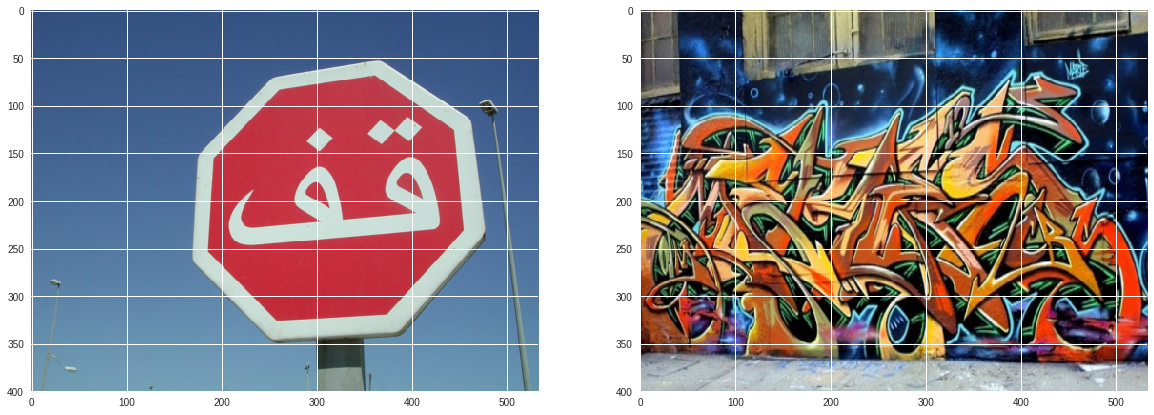

In [0]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## These are the layers specified from the paper
    # (why it's important to see your entire model sometimes)
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    img = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        img = layer(img)
        if name in layers:
            features[layers[name]] = img
            
    return features

In [0]:
def gram_matrix(tensor):
    """ Takes in a tensor which is the output of a convultional layer
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    # batchsize (which we toss), depth (number of feature maps), height, and width
    _, depth, height, width = tensor.size()
    
    # Reshaping the tensor so we're multiplying the features for each channel\
    # it's a 2d shape with its spacial dimensions flattened (height, width)
    tensor = tensor.view(depth, height * width)
    
    # calculate the gram matrix (multiplying the tensor times its transpose)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [0]:
# adding weights to the style features, giving them more importance over others
# higher weights in the beginning are for larger brush strokes
# heigher weights near the end are for more fined tuned details

# notice we are excluding `conv4_2`, which is our content representation
style_weights = {'conv1_1': 0.6,
                 'conv2_1': 0.6,
                 'conv3_1': 0.6,
                 'conv4_1': 0.7,
                 'conv5_1': 0.7}

# we want to give our style loss a much larger weight than the content loss
# good starting points are content weight = 1 and style weight 1 * 10^6
content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  33275082.0


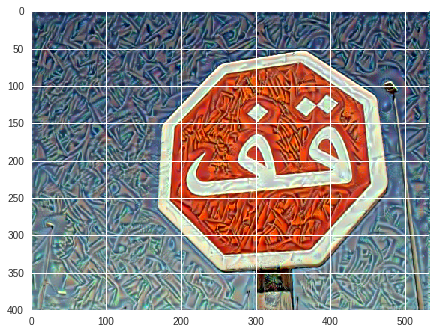

Total loss:  12236245.0


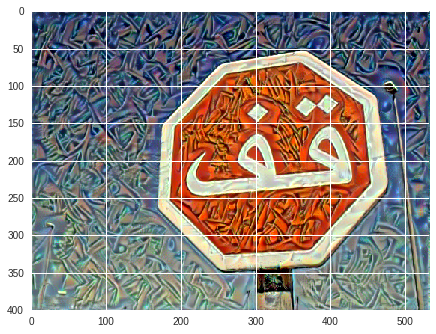

Total loss:  6317682.0


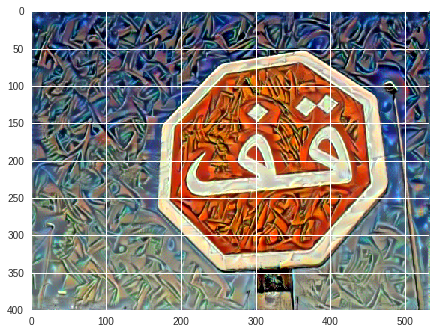

Total loss:  3816292.25


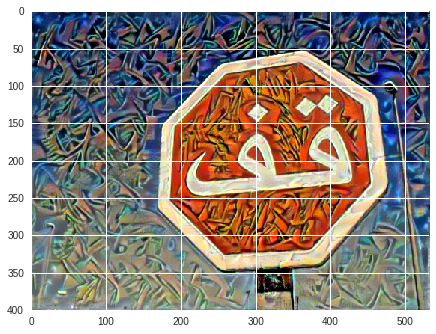

In [0]:
# for displaying the target image, intermittently
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 10000  # number of iterations to update the target image

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    # comparing the content features and the target features at the overlapping
    # convulution layer and calculating the mean squared difference
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
      
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        
        # feeding the data at layer[i] into the gram_matrix function
        target_gram = gram_matrix(target_feature)
        
        _, depth, height, width = target_feature.shape
        
        # LOTS OF LAYERS HERE, style_gram LOOP, AND TAKING THE STYLE LOSS PER
        # LAYER WITH CONSIDERATION OF THE CORRESPONDING WEIGHT THAT WAS DEFINED
        # IN THE ABOVE CELL
        # 
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (depth * height * width)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## So this is actually from a previous transfer, just loved it so kept it here

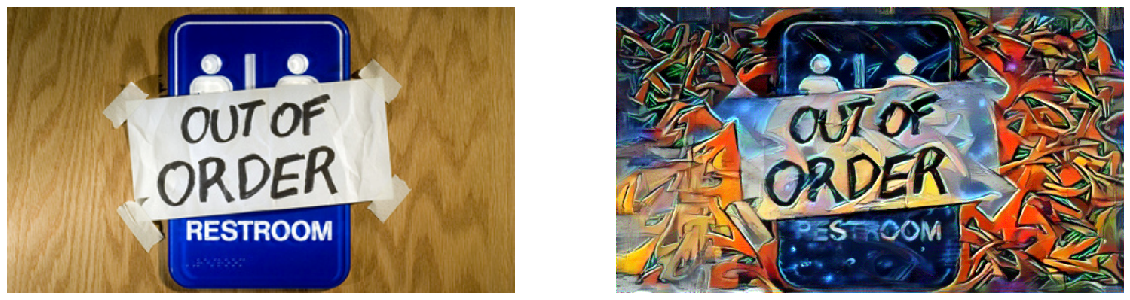

In [0]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Removing axis and ticks
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])


ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])


ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
fig.savefig('out_of_order_comparision.jpg')

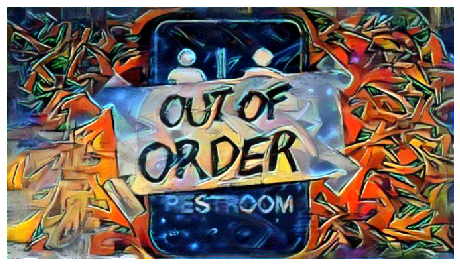

In [0]:
# display content and final, target image
fig, ax3 = plt.subplots()

# Removing axis and ticks

ax3.grid(False)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.imshow(im_convert(target))
fig.savefig('out_of_order_target_weights_1_75_75_7_7_at_10k_steps.jpg')

style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.75,
                 'conv4_1': 0.7,
                 'conv5_1': 0.7}
                 
10000 steps                 